#꽃 이미지 분류 및 예측예제(GRU)

In [53]:
#flower_photo 디렉토리 밑에 daisy, dandelion, roses, sunflowers, tulips 디렉토리 존재, 약 3670개 사진
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow.keras import layers
import os
import pathlib
import urllib.request
import tarfile

#데이터 다운로드 함수
def download_and_extract_data():
    #데이터 URL
    dataset_url="https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz";
    
    #다운로드할 디렉토리 생성
    download_dir=os.path.join(os.getcwd(),"flower_dataset");
    os.makedirs(download_dir, exist_ok=True);
    
    #파일 다운로드
    tgz_path=os.path.join(download_dir, "flower_photos.tgz")
    
    if not os.path.exists(tgz_path):
        print("데이터셋 다운로드 중...");
        urllib.request.urlretrieve(dataset_url, tgz_path);
        print("다운로드 완료!");
        
    #압축해제
    if not os.path.exists(os.path.join(download_dir, "flower_photos")):
        print("압축 해제중...");
        with tarfile.open(tgz_path) as tar:
            tar.extractall(path=download_dir);
        print("압축 해제 완료!");
        
    return os.path.join(download_dir,"flower_photos")

#데이터 다운로드 및 경로 설정
data_dir=download_and_extract_data();
data_dir=pathlib.Path(data_dir);
        

In [33]:
#클래스 및 이미지 개수 확인
classes=sorted([item.name for item in data_dir.glob("*/") if item.is_dir()]);
image_count=len(list(data_dir.glob("*/*.jpg")));
print(f"발견된 클래스: {classes}");
print(f"총 이미지 개수: {image_count}");

#각 클래스별 이미지 개수 확인
for class_name in classes:
    class_images=len(list(data_dir.glob(f"{class_name}/*")));
    print(f"{class_name}: {class_images} 개 이미지");
    


발견된 클래스: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
총 이미지 개수: 3670
daisy: 633 개 이미지
dandelion: 898 개 이미지
roses: 641 개 이미지
sunflowers: 699 개 이미지
tulips: 799 개 이미지


In [40]:
#이미지 크기 및 배치 크기 설정
img_height=180;
img_width=180;
batch_size=32;

#훈련 데이터 생성
train_ds=tf.keras.preprocessing.image_dataset_from_directory(
    str(data_dir),
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
);

#검증 데이터셋 생성
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    str(data_dir),
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [41]:
# 클래스 이름 확인
class_names = train_ds.class_names;
print("클래스:", class_names);
num_classes = len(class_names);

# 데이터셋 성능 최적화
AUTOTUNE = tf.data.AUTOTUNE;
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE);
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE);

# 데이터 증강 레이어 정의
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
]);


클래스: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


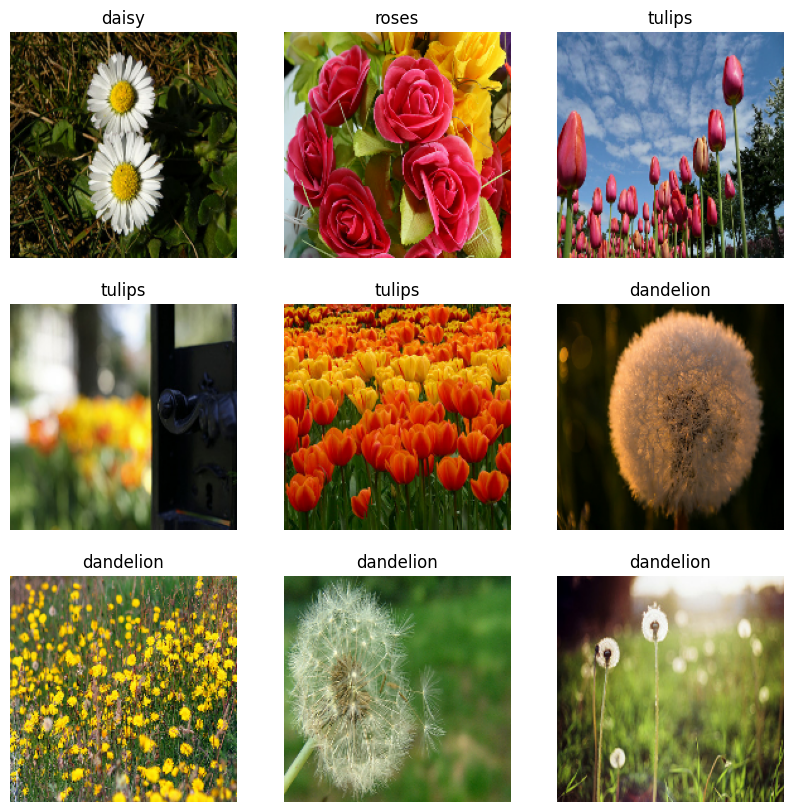

In [42]:
#샘플 이미지 시각화
plt.figure(figsize=(10,10));
for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3,3,i+1);
        plt.imshow(images[i].numpy().astype("uint8"));
        plt.title(class_names[labels[i]]);
        plt.axis("off");
plt.show();

In [45]:
# CNN 모델 구성
model = tf.keras.Sequential([
    data_augmentation,
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

#모델 컴파일
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
);

#모델 구조 출력
print(model.summary());

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [48]:
#Early Stopping 콜백 설정
callbacks=[
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=3,
        restore_best_weights=True
    )
]

#모델 학습
epochs=15;
history=model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks
);


Epoch 1/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 26s 242ms/step - accuracy: 0.3312 - loss: 1.5415 - val_accuracy: 0.4946 - val_loss: 1.2248
Epoch 2/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 22s 239ms/step - accuracy: 0.5236 - loss: 1.1582 - val_accuracy: 0.5954 - val_loss: 1.0004
Epoch 3/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 22s 237ms/step - accuracy: 0.6022 - loss: 1.0094 - val_accuracy: 0.6063 - val_loss: 0.9587
Epoch 4/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 23s 246ms/step - accuracy: 0.6236 - loss: 0.9450 - val_accuracy: 0.6444 - val_loss: 0.8806
Epoch 5/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 24s 262ms/step - accuracy: 0.6594 - loss: 0.8951 - val_accuracy: 0.6703 - val_loss: 0.8545
Epoch 6/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 23s 249ms/step - accuracy: 0.6667 - loss: 0.8380 - val_accuracy: 0.6362 - val_loss: 0.9771
Epoch 7/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 23s 248ms/step - accuracy: 0.6679 - loss: 0.8442 - val_accuracy: 0.6608 - val_loss: 0.8763
Epoch 8/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 23s 254ms/step - accuracy: 0.6760 - loss: 0.8194 - val_accu

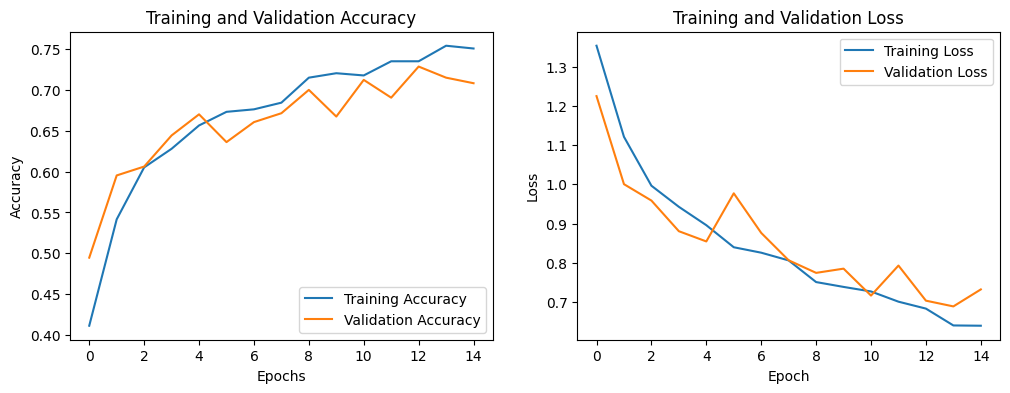

In [49]:
#학습결과 시각화
acc=history.history["accuracy"];
val_acc=history.history["val_accuracy"];
loss=history.history["loss"];
val_loss=history.history["val_loss"];

epochs_range=range(len(acc));

plt.figure(figsize=(12,4));
plt.subplot(1,2,1);
plt.plot(epochs_range, acc, label="Training Accuracy");
plt.plot(epochs_range, val_acc, label="Validation Accuracy");
plt.title("Training and Validation Accuracy");
plt.xlabel("Epochs");
plt.ylabel("Accuracy");
plt.legend(loc="lower right");

plt.subplot(1,2,2);
plt.plot(epochs_range, loss, label="Training Loss");
plt.plot(epochs_range, val_loss, label="Validation Loss");
plt.title("Training and Validation Loss");
plt.xlabel("Epoch");
plt.ylabel("Loss");
plt.legend(loc="upper right");
plt.show();

In [50]:
#모델 저장
model.save("./model/flower_classification_model.h5");
print("모델이 'flower_classification_model.h5'로 저장되었습니다.");

모델이 'flower_classification_model.h5'로 저장되었습니다.


저장된 모델이 성공적으로 로드되었습니다.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
이 이미지는 'roses' (31.90% 확률) 입니다.


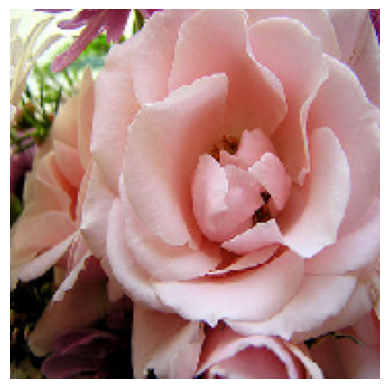

In [52]:
#저장된 모델 불러오기
from tensorflow.keras.models import load_model

model_path="./model/flower_classification_model.h5"; #저장된 모델 경로
loaded_model=load_model(model_path);
print("저장된 모델이 성공적으로 로드되었습니다.");

#저장된 모델을 활용한 이미지 예측 함수
def predict_flower_with_loaded_model(img_path, model, class_names):
    """
    이미지 경로와 모델을 입력받아 예측 결과를 출력하고 이미지를 시각화하는 함수
    Parameters:
        img_path(str): 예측할 이미지 파일 경로
        model(tf.keras.Model): 저장된 모델
        class_names(list): 클래스 이름 리스트
    """
    #이미지 로드 및 전처리
    img=tf.keras.preprocessing.image.load_img(
        img_path, target_size=(img_height, img_width)
    );
    img_array=tf.keras.preprocessing.image.img_to_array(img);
    img_array=tf.expand_dims(img_array,0);   #배치 차원 추가
    
    #예측 수행
    predictions=model.predict(img_array);
    score=tf.nn.softmax(predictions[0]);
    
    #예측 결과 출력
    print(
        "이 이미지는 '{}' ({:.2f}% 확률) 입니다."
        .format(class_names[np.argmax(score)],100*np.max(score))
    );
    
    #이미지 시각화
    plt.imshow(img);
    plt.axis("off");
    plt.show();

#테스트 이미지 경로
#test_image_path = './flower_dataset/flower_photos/daisy/5547758_eea9edfd54_n.jpg'
test_image_path = './flower_dataset/flower_photos/roses/12240303_80d87f77a3_n.jpg';

#예측 실행
predict_flower_with_loaded_model(test_image_path, loaded_model, class_names);

